In [1]:
# import libraries and magics
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

from PIL import Image
import cv2 # install opencv, if you don't already have it (https://pypi.org/project/opencv-python/)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras

# 1. Train an artificial neural network for flower species classification using the training set of dataset 1.

The training dataset is saved as a ```numpy``` array and contains a total of 1678 images from 10 classes. Each RBG image is of size $300\times 300 \times 3$. The 10 classes and its label encodings are:

| Flower Species | Roses | Magnolias | Lilies | Sunflowers | Orchids | Marigold | Hibiscus | Firebush | Pentas | Bougainvillea |
| ---- -----     | ------| ----------| -------| -----------| --------| ---------| ---------| ---------| -------| --------------|
| Label          |  0    |    1      |    2   |    3       |    4    |    5     |   6      |   7      |   8    |       9       |

Let's visualize the dataset:

In [2]:
# Loading Training Data
X_train = np.load('data_train.npy').T
t_train = np.load('labels_train.npy')

print(X_train.shape, t_train.shape)

(1658, 270000) (1658,)


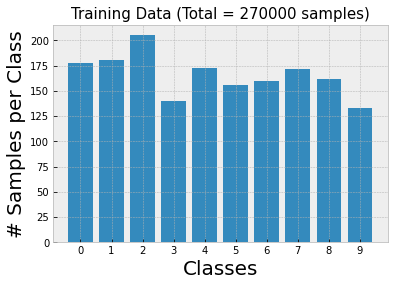

In [4]:
# Counting number samples per class
vals, counts = np.unique(t_train, return_counts=True)

plt.bar(vals, counts)
plt.xticks(range(10),range(10))
plt.xlabel('Classes',size=20)
plt.ylabel('# Samples per Class', size=20)
plt.title('Training Data (Total = '+str(X_train.shape[1])+' samples)',size=15);

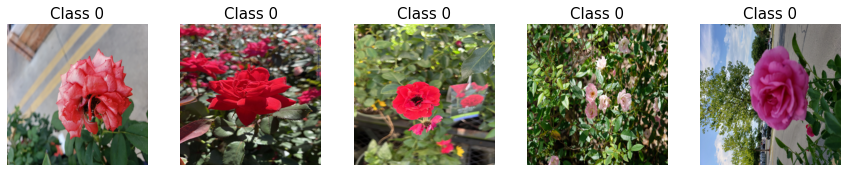

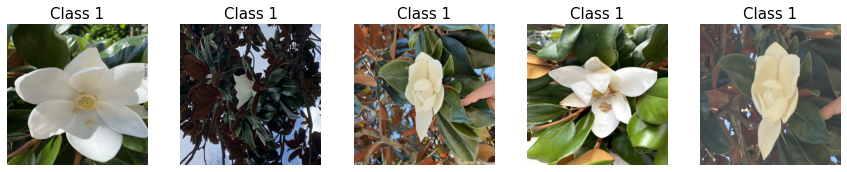

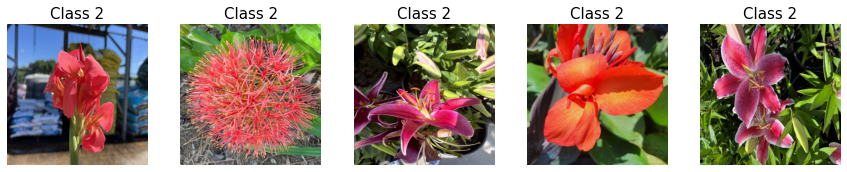

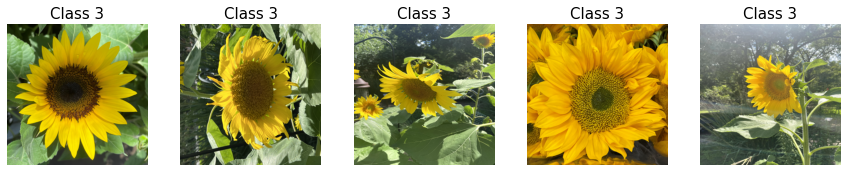

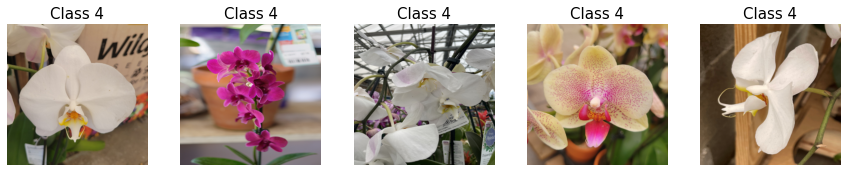

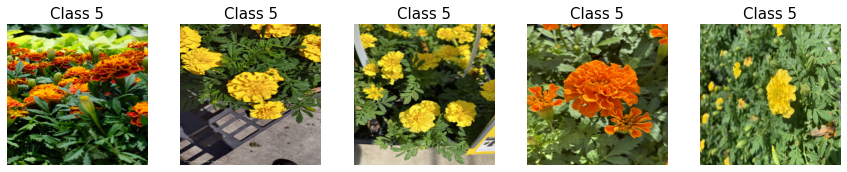

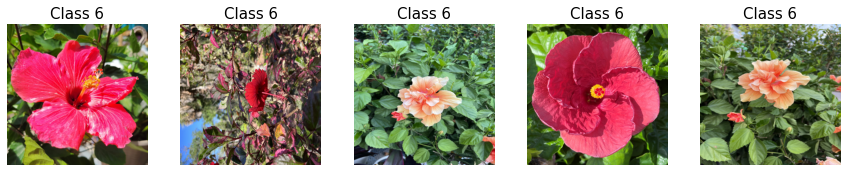

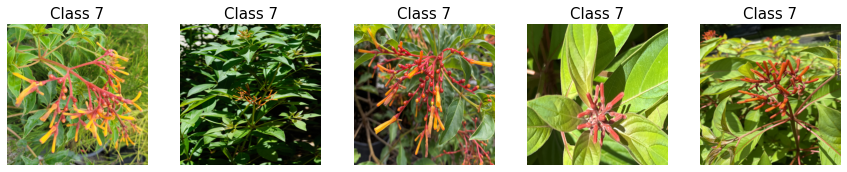

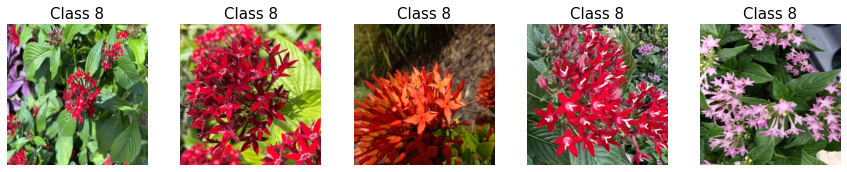

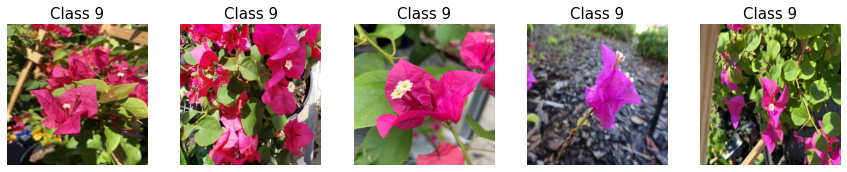

In [4]:
# Displaying some random examples per class
for i in range(0,10):
    rnd_sample = npr.permutation(np.where(t_train==i)[0])
    fig=plt.figure(figsize=(15,15))
    for j in range(5):
        fig.add_subplot(5,5,j+1)
        plt.imshow(X_train[rnd_sample[j],:].reshape((300,300,3)))
        plt.axis('off');plt.title('Class '+str(int(t_train[rnd_sample[j]])),size=15)
    plt.show()
    print('\n\n')

In [3]:
# Split the training data
X_train, X_val, t_train, t_val = train_test_split(X_train, t_train,
                                                  test_size=0.2,
                                                  stratify=t_train,
                                                  shuffle=True,
                                                  random_state=0)

In [4]:
# Scale the training data pixels to between 0 and 1
X_train = X_train / 255.0
X_val = X_val /255.0

# Reshape training data into a 4D tensor and convert into TensorFlow constant tensors with reduced precision
X_train = tf.constant(X_train.reshape((X_train.shape[0],300,300,3)), dtype=tf.float16)
X_val = tf.constant(X_val.reshape((X_val.shape[0], 300,300,3)), dtype=tf.float16)

print(X_train.shape, t_train.shape)
print(X_val.shape, t_val.shape)

2023-12-01 23:19:55.763388: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-01 23:19:57.005886: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78911 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:b7:00.0, compute capability: 8.0
2023-12-01 23:19:57.007666: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78911 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:bd:00.0, compute capability: 8.0


(1326, 300, 300, 3) (1326,)
(332, 300, 300, 3) (332,)


In [5]:
def Evaluate_performance(model, history, name, X_train=X_train, t_train=t_train, X_val=X_val, t_val=t_val):
    # Prediction
    y_train = np.argmax(model.predict(X_train), axis=1)
    y_val = np.argmax(model.predict(X_val), axis=1)
    
    # Print performance
    print(f'{name} Performance:\n')
    print('Training set:')
    print(f'{classification_report(t_train, y_train)}')
    print(f'Accuracy: {accuracy_score(y_train, t_train)}')
    print('Confusion Matrix:')
    print(confusion_matrix(t_train, y_train))

    print('\nValidation set:')
    print(f'{classification_report(t_val, y_val)}')
    print(f'Accuracy: {accuracy_score(y_val, t_val)}')
    print('Confusion Matrix:')
    print(confusion_matrix(t_val, y_val))
    
    # Display learning curve
    key_names = list(history.history.keys())
    colors = ['-or','--b','-og','--k']

    # Training loss
    plt.figure(figsize=(16,5))
    plt.subplot(1, 2, 1)
    for i in [0,2]:
        plt.plot(history.history[key_names[i]], colors[i], label=key_names[i])
    plt.legend()
    plt.title('Learning Curves with loss');

    # Validaiton loss
    plt.subplot(1, 2, 2)
    for i in [1,3]:
        plt.plot(history.history[key_names[i]], colors[i], label=key_names[i])
    plt.legend()
    plt.title('Learning Curves with accuracy');

In [9]:
# Model 1: Only use ANN with 2 hidden layers
ANN = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[300,300,3]),
    keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(150, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

ANN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 270000)            0         
                                                                 
 dense_3 (Dense)             (None, 300)               81000300  
                                                                 
 dropout_2 (Dropout)         (None, 300)               0         
                                                                 
 dense_4 (Dense)             (None, 150)               45150     
                                                                 
 dropout_3 (Dropout)         (None, 150)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                1510      
                                                                 
Total params: 81,046,960
Trainable params: 81,046,960


In [10]:
opt = keras.optimizers.Nadam(learning_rate = 0.00001)
ANN.compile(optimizer=opt,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) # Early stopping
cp = keras.callbacks.ModelCheckpoint('Model/ANN.h5', monitor='val_loss', save_best_only=True) # Checkpoint

history = ANN.fit(X_train, t_train, 
                  epochs=100, 
                  batch_size=32,
                  validation_data=(X_val, t_val),
                  callbacks=[es, cp])

Epoch 1/100
42/42 [==============================] - 3s 54ms/step - loss: 2.2967 - accuracy: 0.1621 - val_loss: 1.9404 - val_accuracy: 0.2711
Epoch 2/100
42/42 [==============================] - 2s 48ms/step - loss: 1.9170 - accuracy: 0.2956 - val_loss: 1.8044 - val_accuracy: 0.3886
Epoch 3/100
42/42 [==============================] - 2s 47ms/step - loss: 1.7725 - accuracy: 0.3529 - val_loss: 1.6839 - val_accuracy: 0.4247
Epoch 4/100
42/42 [==============================] - 2s 47ms/step - loss: 1.6748 - accuracy: 0.4020 - val_loss: 1.6806 - val_accuracy: 0.4307
Epoch 5/100
42/42 [==============================] - 1s 15ms/step - loss: 1.6284 - accuracy: 0.4148 - val_loss: 1.6874 - val_accuracy: 0.4127
Epoch 6/100
42/42 [==============================] - 2s 49ms/step - loss: 1.5427 - accuracy: 0.4600 - val_loss: 1.5991 - val_accuracy: 0.4307
Epoch 7/100
42/42 [==============================] - 2s 47ms/step - loss: 1.4825 - accuracy: 0.4796 - val_loss: 1.5002 - val_accuracy: 0.4849
Epoch 

ANN Performance:

Training set:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       141
         1.0       1.00      1.00      1.00       144
         2.0       1.00      1.00      1.00       164
         3.0       1.00      1.00      1.00       112
         4.0       1.00      1.00      1.00       138
         5.0       1.00      1.00      1.00       125
         6.0       0.99      1.00      1.00       128
         7.0       1.00      1.00      1.00       138
         8.0       1.00      0.98      0.99       130
         9.0       0.99      1.00      1.00       106

    accuracy                           1.00      1326
   macro avg       1.00      1.00      1.00      1326
weighted avg       1.00      1.00      1.00      1326

Accuracy: 0.9984917043740573
Confusion Matrix:
[[141   0   0   0   0   0   0   0   0   0]
 [  0 144   0   0   0   0   0   0   0   0]
 [  0   0 164   0   0   0   0   0   0   0]
 [  0   0   0 112   0   0   0   0

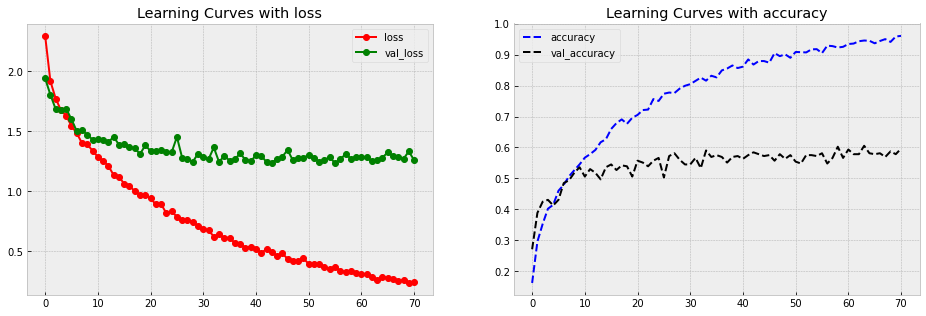

In [11]:
model = keras.models.load_model('Model/ANN.h5')
Evaluate_performance(model=model, history=history, name='ANN')

In [22]:
# Model 2: With convolution layers
CNN = keras.models.Sequential([
    keras.layers.Conv2D(64, 10, activation='relu', padding='same', input_shape=[300,300,3], kernel_initializer='lecun_normal'), 
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2), 
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(128, 5, activation='relu', padding='same', kernel_initializer='lecun_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='lecun_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(150, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

CNN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 300, 300, 64)      19264     
                                                                 
 batch_normalization_6 (Batc  (None, 300, 300, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 150, 150, 64)     0         
 2D)                                                             
                                                                 
 dropout_14 (Dropout)        (None, 150, 150, 64)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 150, 150, 128)     204928    
                                                                 
 batch_normalization_7 (Batc  (None, 150, 150, 128)   

In [23]:
opt = keras.optimizers.Nadam(learning_rate = 0.00001)
CNN.compile(optimizer=opt,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15) # Early stopping
cp = keras.callbacks.ModelCheckpoint('Model/CNN.h5', save_best_only=True) # Checkpoint

history = CNN.fit(X_train, t_train, 
                  epochs=100, 
                  batch_size=32,
                  validation_data=(X_val, t_val),
                  callbacks=[es, cp])

Epoch 1/100
42/42 [==============================] - 5s 111ms/step - loss: 2.6433 - accuracy: 0.2353 - val_loss: 2.4553 - val_accuracy: 0.1777
Epoch 2/100
42/42 [==============================] - 3s 67ms/step - loss: 1.6066 - accuracy: 0.4585 - val_loss: 3.6616 - val_accuracy: 0.1988
Epoch 3/100
42/42 [==============================] - 3s 67ms/step - loss: 1.2844 - accuracy: 0.5611 - val_loss: 4.3824 - val_accuracy: 0.1958
Epoch 4/100
42/42 [==============================] - 3s 67ms/step - loss: 1.0230 - accuracy: 0.6523 - val_loss: 4.7119 - val_accuracy: 0.2651
Epoch 5/100
42/42 [==============================] - 3s 67ms/step - loss: 0.8615 - accuracy: 0.6923 - val_loss: 5.2100 - val_accuracy: 0.2289
Epoch 6/100
42/42 [==============================] - 3s 67ms/step - loss: 0.6808 - accuracy: 0.7647 - val_loss: 4.2672 - val_accuracy: 0.3133
Epoch 7/100
42/42 [==============================] - 3s 67ms/step - loss: 0.5591 - accuracy: 0.8107 - val_loss: 3.3417 - val_accuracy: 0.3313
Epoch

CNN Performance:

Training set:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       141
         1.0       1.00      1.00      1.00       144
         2.0       1.00      1.00      1.00       164
         3.0       1.00      1.00      1.00       112
         4.0       1.00      1.00      1.00       138
         5.0       1.00      1.00      1.00       125
         6.0       1.00      1.00      1.00       128
         7.0       1.00      1.00      1.00       138
         8.0       1.00      1.00      1.00       130
         9.0       1.00      1.00      1.00       106

    accuracy                           1.00      1326
   macro avg       1.00      1.00      1.00      1326
weighted avg       1.00      1.00      1.00      1326

Accuracy: 1.0
Confusion Matrix:
[[141   0   0   0   0   0   0   0   0   0]
 [  0 144   0   0   0   0   0   0   0   0]
 [  0   0 164   0   0   0   0   0   0   0]
 [  0   0   0 112   0   0   0   0   0   0]
 [  0

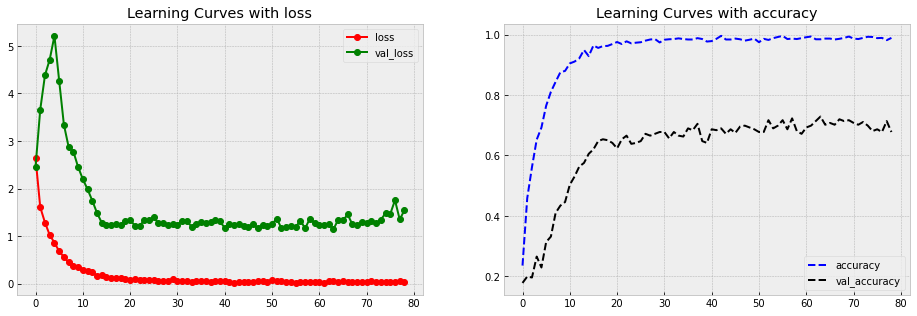

In [24]:
model = keras.models.load_model('Model/CNN.h5')
Evaluate_performance(model=model, history=history, name='CNN')

**Transfer Learning**

In [28]:
base_model = keras.applications.Xception(
    weights='imagenet', 
    input_shape=(300, 300, 3),
    include_top=False
)

base_model.trainable = False
inputs = keras.Input(shape=(300, 300, 3))
x_model = base_model(inputs)
x_model_pool = keras.layers.GlobalAveragePooling2D()(x_model)
outputs = keras.layers.Dense(10, activation='softmax')(x_model_pool)
TL = keras.Model(inputs, outputs)

TL.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 300, 300, 3)]     0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_9 (Dense)             (None, 10)                20490     
                                                                 
Total params: 20,881,970
Trainable params: 20,490
Non-trainable params: 20,861,480
_________________________________________________________________


In [29]:
TL.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.001),
           loss='sparse_categorical_crossentropy',
           metrics=['accuracy'])

es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15) # Early stopping
cp = keras.callbacks.ModelCheckpoint('Model/TL.h5', save_best_only=True) # Checkpoint

history = TL.fit(X_train, t_train, 
                 epochs=100, 
                 batch_size=32,
                 validation_data=(X_val, t_val),
                 callbacks=[es, cp])

Epoch 1/100
41/42 [============================>.] - ETA: 0s - loss: 1.6758 - accuracy: 0.5686

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


42/42 [==============================] - 4s 64ms/step - loss: 1.6716 - accuracy: 0.5709 - val_loss: 1.1355 - val_accuracy: 0.7952
Epoch 2/100
42/42 [==============================] - 2s 48ms/step - loss: 0.8406 - accuracy: 0.8658 - val_loss: 0.7335 - val_accuracy: 0.8494
Epoch 3/100
42/42 [==============================] - 2s 46ms/step - loss: 0.5728 - accuracy: 0.8989 - val_loss: 0.5730 - val_accuracy: 0.8765
Epoch 4/100
42/42 [==============================] - 2s 46ms/step - loss: 0.4499 - accuracy: 0.9148 - val_loss: 0.4928 - val_accuracy: 0.8886
Epoch 5/100
42/42 [==============================] - 2s 45ms/step - loss: 0.3727 - accuracy: 0.9284 - val_loss: 0.4486 - val_accuracy: 0.8825
Epoch 6/100
42/42 [==============================] - 2s 45ms/step - loss: 0.3215 - accuracy: 0.9367 - val_loss: 0.3984 - val_accuracy: 0.8976
Epoch 7/100
42/42 [==============================] - 2s 53ms/step - loss: 0.2810 - accuracy: 0.9434 - val_loss: 0.3676 - val_accuracy: 0.9036
Epoch 8/100
42/42 

Transfer learning Performance:

Training set:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       141
         1.0       1.00      1.00      1.00       144
         2.0       1.00      1.00      1.00       164
         3.0       1.00      1.00      1.00       112
         4.0       1.00      1.00      1.00       138
         5.0       1.00      1.00      1.00       125
         6.0       1.00      1.00      1.00       128
         7.0       1.00      1.00      1.00       138
         8.0       1.00      1.00      1.00       130
         9.0       1.00      1.00      1.00       106

    accuracy                           1.00      1326
   macro avg       1.00      1.00      1.00      1326
weighted avg       1.00      1.00      1.00      1326

Accuracy: 1.0
Confusion Matrix:
[[141   0   0   0   0   0   0   0   0   0]
 [  0 144   0   0   0   0   0   0   0   0]
 [  0   0 164   0   0   0   0   0   0   0]
 [  0   0   0 112   0   0   0   0 

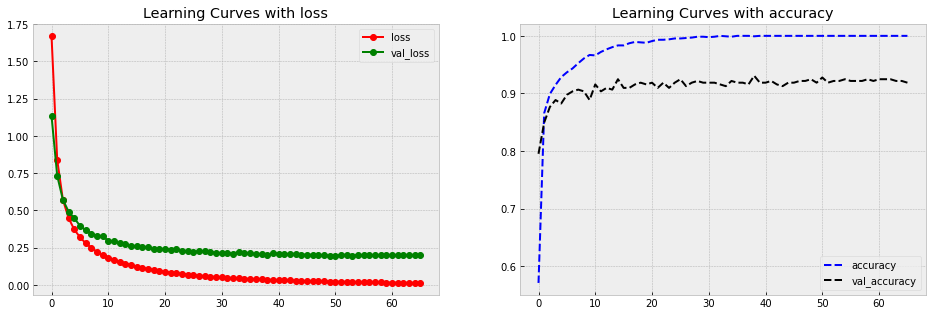

In [30]:
model = keras.models.load_model('Model/TL.h5')
Evaluate_performance(model=model, history=history, name='Transfer learning')

# 2. Train an artificial neural network for object detection using the training set of dataset 2.

In [3]:
bbox = pd.read_csv('train_bounding_boxes.csv')
bbox

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422
...,...,...,...,...,...
554,vid_4_9860.jpg,0.000000,198.321729,49.235251,236.223284
555,vid_4_9880.jpg,329.876184,156.482351,536.664239,250.497895
556,vid_4_9900.jpg,0.000000,168.295823,141.797524,239.176652
557,vid_4_9960.jpg,487.428988,172.233646,616.917699,228.839864


In [4]:
N = len(bbox) # no. of training samples

# Create a numpy array with all images
for i in range(N): 
    filename='training_images/'+bbox['image'][i]
    image = np.array(Image.open(filename))
    image_col = image.ravel()[:,np.newaxis]
    
    if i==0:
        X_train = image_col
    else:
        X_train = np.hstack((X_train, image_col))

# Training feature matrices
X_train = X_train.T

# Training labels
t_train = bbox.drop('image', axis=1).round().to_numpy().astype(int)

X_train.shape, t_train.shape

((559, 770640), (559, 4))

In [5]:
# size of each RGB image
(Nx,Ny,Nz) = image.shape

Nx, Ny, Nz

(380, 676, 3)

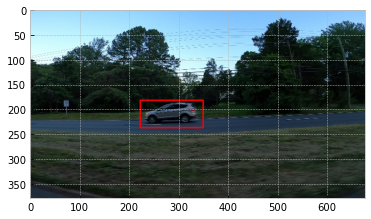

In [6]:
# Example of object visualization using opencv rectangle function
idx=N-1
x= image

plt.imshow(x)
cv2.rectangle(x, (t_train[idx,0], t_train[idx,1]), 
              (t_train[idx,2], t_train[idx,3]), 
              (255, 0, 0), 2);

In [5]:
X_train = X_train / 255.0
t_train = np.vstack((t_train[:,0]/Ny, t_train[:,1]/Nx, t_train[:,2]/Ny, t_train[:,3]/Nx)).T
X_train, X_val, t_train, t_val = train_test_split(X_train, t_train,
                                                  test_size=0.1,
                                                  random_state=0)

X_train = tf.constant(X_train.reshape((X_train.shape[0],Nx,Ny,3)), dtype=tf.float16)
X_val = tf.constant(X_val.reshape((X_val.shape[0], Nx,Ny,3)), dtype=tf.float16)

X_train.shape, t_train.shape, X_val.shape, t_val.shape

2023-11-24 13:21:09.957073: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-24 13:21:11.273741: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78921 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-11-24 13:21:11.278813: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78921 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:4e:00.0, compute capability: 8.0


(TensorShape([503, 380, 676, 3]),
 (503, 4),
 TensorShape([56, 380, 676, 3]),
 (56, 4))

In [6]:
# Build the model
base_model = keras.applications.VGG16(
    weights='imagenet', 
    input_tensor=keras.layers.Input(shape=(224, 224, 3)),
    include_top=False
)

base_model.trainable = False
inputs = keras.Input(shape=(Nx, Ny, Nz))
inputs_norm = keras.layers.BatchNormalization()(inputs)
inputs_rs = keras.layers.Resizing(224, 224)(inputs_norm)

x_model = base_model(inputs_rs)
x_flatten = keras.layers.Flatten()(x_model)
layer1 = keras.layers.Dense(128, activation="selu", kernel_initializer='lecun_normal')(x_flatten)
dropout1 = keras.layers.Dropout(0.1)(layer1)
layer2 = keras.layers.Dense(64, activation="selu", kernel_initializer='lecun_normal')(dropout1)
dropout2 = keras.layers.Dropout(0.1)(layer2)
layer3 = keras.layers.Dense(32, activation="selu", kernel_initializer='lecun_normal')(dropout2)
outputs = keras.layers.Dense(4, activation="sigmoid")(layer3)
VGG = keras.Model(inputs, outputs)

VGG.summary()

2023-11-25 10:42:54.402363: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 10:42:55.740046: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78911 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-11-25 10:42:55.744297: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78911 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:4e:00.0, compute capability: 8.0


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 380, 676, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 380, 676, 3)      12        
 ormalization)                                                   
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                             

In [7]:
VGG.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.001),
                      loss='mean_squared_error')

es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
cp = keras.callbacks.ModelCheckpoint('Model/VGG.h5', save_best_only=True)

history = VGG.fit(X_train, t_train, 
                  epochs=100, 
                  batch_size=16,
                  validation_data=(X_val, t_val),
                  callbacks=[es, cp])

2023-11-24 13:21:34.023495: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2023-11-24 13:21:35.450200: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2023-11-24 13:21:36.191368: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-24 13:21:36.193060: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-24 13:21:36.193074: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2023-11-24 13:21:36.194451: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-24 13:21:36.194491: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-11-24 13:21:37.982435: I tensorflow/stream_executor/cuda/c

32/32 [==============================] - 9s 133ms/step - loss: 0.2213 - val_loss: 0.2246
Epoch 2/100
32/32 [==============================] - 1s 34ms/step - loss: 0.1604 - val_loss: 0.1050
Epoch 3/100
32/32 [==============================] - 1s 32ms/step - loss: 0.1010 - val_loss: 0.0609
Epoch 4/100
32/32 [==============================] - 1s 33ms/step - loss: 0.0555 - val_loss: 0.0521
Epoch 5/100
32/32 [==============================] - 1s 33ms/step - loss: 0.0458 - val_loss: 0.0421
Epoch 6/100
32/32 [==============================] - 1s 33ms/step - loss: 0.0373 - val_loss: 0.0511
Epoch 7/100
32/32 [==============================] - 1s 33ms/step - loss: 0.0333 - val_loss: 0.0455
Epoch 8/100
32/32 [==============================] - 1s 33ms/step - loss: 0.0341 - val_loss: 0.0497
Epoch 9/100
32/32 [==============================] - 1s 34ms/step - loss: 0.0332 - val_loss: 0.0495
Epoch 10/100
32/32 [==============================] - 1s 36ms/step - loss: 0.0310 - val_loss: 0.0426
Epoch 11/1

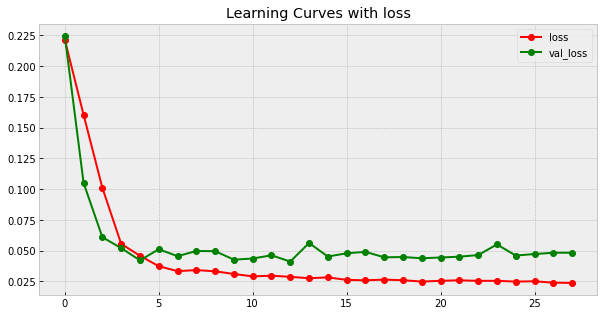

In [8]:
keys = list(history.history.keys())
colors = ['-or','-og']

plt.figure(figsize=(10,5))
for i in [0,1]:
    plt.plot(history.history[keys[i]], colors[i], label=keys[i])
plt.legend()
plt.title('Learning Curves with loss');